# <div style="text-align: center">Neural Networks - Kohn-Sham Mapping</div> 
 
## <div style="text-align: center">Jon Vandermause, Steven Torrisi, Simon Batzner</div> 

## <div style="text-align: center">Gaussian Potential-to-Energy </div> 

In [72]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

import numpy as np
import matplotlib.pyplot as plt
import argparse

from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from keras import optimizers
from keras.callbacks import TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split
from math import sqrt
from KRR_reproduce import *

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Parameters

In [103]:
SEED = 42
ev2kcal = 1/0.043       # conversion factor
EPOCHS = 50000          # maximum number of training epochs
OPTIMIZER = 'sgd'
LEARNING_RATE = 0.01   # larger means faster learning, more aggressive, set this in [0.001 - 0.003]
GRID_SPACE = 0.6        # instead of 0.08 in the paper -- makes it faster and the input much smaller
DECAY = 0.0             # decay learning rate as training advances
SIM_NO = 201            # total number of data points
M = 15               # number of training points
ev2kcal = 1/0.043       # conversion factor

HIDDEN = (10, 10)
    
# path to data
os.environ['PROJDIR'] = '/Users/simonbatzner1/Desktop/Research/Research_Code/ML-electron-density'
STR_PREF = os.environ['PROJDIR']+'/Aluminium_Dataset/Store/'

# ignore tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Load data

In [104]:
# load MD results
MD_pos = np.load(STR_PREF+'MD_positions.npy')
MD_ens = np.load(STR_PREF+'MD_energies.npy')

In [105]:
pos = []
ens = []
fours = []

for n in range(SIM_NO):
    # load arrays
    en_curr = np.reshape(np.load(STR_PREF+'en_store/energy'+str(n)+'.npy'),(1))[0]
    pos_curr = np.load(STR_PREF+'pos_store/pos'+str(n)+'.npy')
    four_curr = np.load(STR_PREF+'four_store/four'+str(n)+'.npy')
    
    # store arrays
    ens.append(en_curr)
    pos_curr = pos_curr.flatten()
    pos.append(pos_curr)
    fours.append(four_curr)

# convert to np arrays
ens = np.array(ens)
pos = np.array(pos)
fours = np.array(fours)

## Network functions

In [106]:
def init_architecture(input_shape, hidden_size, summary, activation='relu'):
    """
    Built Neural Network using Keras

    :param input_shape: shape of the input data
    :param hidden_size: tuple of number of hidden layers, eg. (30, 30, 40) builds a network with hidden layers 30-30-40
    :param summary: boolean, true plots a summary
    :param activation: activiation function
    :return: keras Sequential model
    """
    model = Sequential()
    print(input_shape)

    # hidden layers
    model.add(Dense(hidden_size[0], input_shape=input_shape, activation=activation))
    for layer_size in hidden_size[1:]:
        model.add(Dense(layer_size, activation=activation))
        model.add(Dropout(0.2))

    # output layer
    model.add(Dense(1, activation='linear'))

    if summary:
        model.summary()

    return model

In [107]:
def train(model, training_data, training_labels, validation_data, validation_labels, batchsize=64):
    """"
    Train Neural Network model
    """
    history = model.fit(training_data, training_labels, validation_data=(validation_data, validation_labels),
                        batch_size=batchsize,
                        verbose=0, shuffle=True)
    return history

## Setup training and test data

In [108]:
data = pos
labels = ens

# define training and test indices
train_indices = [int(n) for n in np.round(np.linspace(0,200,M))]
test_indices = [n for n in range(201) if n not in train_indices]

if len(train_indices) != M: 
    print("Size of training set doesn't match the M specified")
    
x_train = np.array([data[n] for n in train_indices])
x_test = np.array([data[n] for n in test_indices])
y_train = np.array([labels[n] for n in train_indices])
y_test =np.array([labels[n] for n in test_indices])

# convert to np arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape)
print(x_test.shape)
print(y_test.shape)

(15, 12)
(186, 12)
(186,)


## Build model and train

In [109]:
# build neural net
model = init_architecture(input_shape=data[0].shape, hidden_size=tuple(HIDDEN), summary=True,
                          activation='tanh')

# pick optimizer
adam = optimizers.Adam(lr=LEARNING_RATE, decay=DECAY)
sgd = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)

if OPTIMIZER == 'adam': 
    model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mse'])
elif OPTIMIZER == 'sgd': 
    model.compile(optimizer=sgd, loss='mean_squared_error', metrics=['mse'])
else: 
    "Default optimizer ADAM being used..."
    model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mse'])
    
# Early stopping on validation error
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=500,
                   verbose=10, mode='auto')

# Log graph and gradients
tb = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=1, write_graph=True, write_grads=True,
                 write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

# Save training history
history = model.fit(x_train, y_train, epochs=EPOCHS, verbose=0, validation_split=0.2, callbacks=[es, tb])

(12,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 10)                130       
_________________________________________________________________
dense_29 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 11        
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________
Epoch 01015: early stopping


## Results

In [110]:
from sklearn.metrics import mean_absolute_error
# eval on training data
y_true_train, y_pred_train = y_train, model.predict(x_train)

# eval on test data
y_true, y_pred = y_test, model.predict(x_test)

# print results
print("\n\nMAE on training data in [eV]: \t{}".format(mean_absolute_error(y_true_train, y_pred_train)*ev2kcal))
print("MAE on test data in [eV]: \t{}\n\n".format(mean_absolute_error(y_true, y_pred)*ev2kcal))
print("\nPrediction on test data:")
print("\n\tPred   |   True\n")
print(np.c_[y_pred, y_true])



MAE on training data in [eV]: 	1.2827136228624954
MAE on test data in [eV]: 	1.7901927024203397



Prediction on test data:

	Pred   |   True

[[-227.83833313 -227.87495202]
 [-227.83833313 -227.83845541]
 [-227.83833313 -227.83385737]
 [-227.83833313 -227.86424202]
 [-227.83833313 -227.84035463]
 [-227.83833313 -227.76541689]
 [-227.83833313 -227.76301767]
 [-227.83833313 -227.82810937]
 [-227.83833313 -227.84445525]
 [-227.83833313 -227.78635362]
 [-227.83833313 -227.75901201]
 [-227.83833313 -227.80722149]
 [-227.83833313 -227.85335868]
 [-227.83833313 -227.82986409]
 [-227.83833313 -227.83209897]
 [-227.83833313 -227.85556294]
 [-227.83833313 -227.87406438]
 [-227.83833313 -227.86525156]
 [-227.83833313 -227.81552219]
 [-227.83833313 -227.76311957]
 [-227.83833313 -227.79972094]
 [-227.83833313 -227.8249323 ]
 [-227.83833313 -227.74434902]
 [-227.83833313 -227.71942569]
 [-227.83833313 -227.77464618]
 [-227.83833313 -227.7762786 ]
 [-227.83833313 -227.75392988]
 [-227.83833313 -2

dict_keys(['mean_squared_error', 'val_loss', 'val_mean_squared_error', 'loss'])


Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

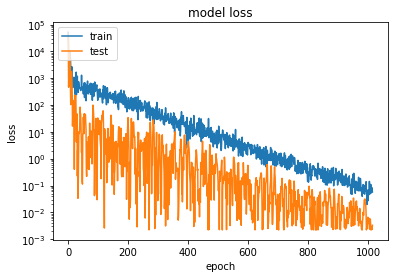

In [111]:
# Plot loss history
print(history.history.keys());
plt.semilogy(history.history['loss']);
plt.semilogy(history.history['val_loss']);
plt.title('model loss');
plt.ylabel('loss');
plt.xlabel('epoch');
plt.legend(['train', 'test'], loc='upper left');
plt.show()

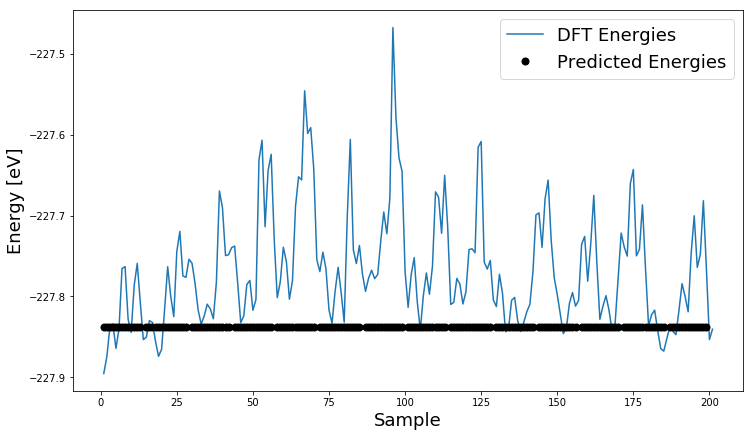

In [112]:
fig = plt.figure(figsize=(12, 7)); 
plt.plot(np.linspace(1, SIM_NO, SIM_NO), ens, label = 'DFT Energies'); 
plt.plot(test_indices, y_pred, 'k.', MarkerSize = 10, mew = 3, label = 'Predicted Energies'); 
plt.legend(fontsize = 18)
plt.xlabel('Sample', fontsize = 18)
plt.ylabel('Energy [eV]', fontsize = 18)
plt.show(); 

For comparison, from [1]: "The MAE that is introduced by the PBE approximation on the H2 data set is 2.3 kcal/mol (compared to exact CI calculations)"" 

[1] Brockherde et al. Bypassing the Kohn-Sham equations with machine learning. Nature Communications 8, 872 (2017)